# Import libraries and environment configuration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from collections import defaultdict, Counter
import random

import tensorflow as tf

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

!pip install rouge-score
!pip install flask-ngrok

from rouge_score import rouge_scorer, scoring

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=8c22fc7103071830560c324e821ff0d8952b9312cf9c17f8f1f424baba9705bf
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
# Use TPU

print("Tensorflow version " + tf.__version__)

#try:
  #tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
 # print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
#except ValueError:
 # raise BaseException('ERROR: Not connected to a TPU runtime.')

#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.15.0


Source for the TPU enabling code snippet: https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=FpvUOuC3j27n

# Preprocessing and analysis

In [ ]:
fileroute = 'https://github.com/U20212419/TA_TACC/blob/main/corpus.csv?raw=true'
raw_dataset = pd.read_csv(fileroute, delimiter=',', encoding='latin-1')

In [ ]:
raw_dataset.head()

,title,text
0,Atuqwan haka,"Huk shumaq shipash, chakwan mamallanwan qichwa..."
1,Awilan waatashqa wamra,"Huk kutishi, huk aqtupaakuq wamra kanaq. Payqa..."
2,Ukushkuna,Unayshi kimsa panituri ukushkuna kawayaanaq. C...
3,Ashnuwan atuq,Unay wichanshi Tiwllu shutishqa runa huk ashnu...
4,Utush Kuru,Unayshi kay shumaq pampachaw papata muruq huk ...


Central quechua consists of 24 letters or spellings:

6 vocals: a, i, u, aa, ii, uu

18 consonants: ch, h, k, l, ll, m, n, ñ, p, q, r, s, sh, t, ts, tr, w, y.

https://cdn.www.gob.pe/uploads/document/file/5008213/manual-escritura-lengua-quechua-central-comprimido.pdf?v=1692305602

In [ ]:
alphabet = ['a', 'i', 'u', 'aa', 'ii', 'uu', 'ch', 'h', 'k', 'l', 'll', 'm', 'n', 'ñ', 'p', 'q', 'r', 's', 'sh', 't', 'ts', 'tr', 'w', 'y']
punctuation = ['.', ',', '!', '?', ':', ';', '-', '(', ')', '[', ']', '{', '}', '"', "'", '...', '–', '—', '“', '”', '‘', '’', '¡', '¿', '…', '«', '»', '_', '/', '*']
print("Alphabet length: {}".format(len(alphabet)))

# Regex to detect words that contain spellings that aren't in the alphabet
alphabet_pattern = '|'.join(re.escape(char) for char in alphabet + punctuation)
pattern = f'^(?:{alphabet_pattern})+$'
print("Regex: {}".format(pattern))

Alphabet length: 24
Regex: ^(?:a|i|u|aa|ii|uu|ch|h|k|l|ll|m|n|ñ|p|q|r|s|sh|t|ts|tr|w|y|\.|,|!|\?|:|;|\-|\(|\)|\[|\]|\{|\}|"|'|\.\.\.|–|—|“|”|‘|’|¡|¿|…|«|»|_|/|\*)+$


In [ ]:
def is_valid_word(word):
        return bool(re.match(pattern, word, re.IGNORECASE))

def filter_text(text):
    words = text.split()
    valid_words = filter(is_valid_word, words)
    return ' '.join(valid_words)

def remove_punctuation(text):
    text = re.sub(f"[{re.escape(''.join(punctuation))}]", "", text)
    return text

def preprocessing(dataset):
    # Remove punctuation
    dataset['text'] = dataset['text'].apply(remove_punctuation)
    dataset['title'] = dataset['title'].apply(remove_punctuation)

    # Remove foreign spellings
    dataset['text'] = dataset['text'].apply(filter_text)
    dataset['title'] = dataset['title'].apply(filter_text)

    # Convert to lowercase
    dataset['text'] = dataset['text'].str.lower()
    dataset['title'] = dataset['title'].str.lower()

    # Remove duplicate spaces
    dataset['text'] = dataset['text'].apply(lambda x: ' '.join(x.split()))
    dataset['title'] = dataset['title'].apply(lambda x: ' '.join(x.split()))

    # Remove empty rows if any
    dataset = dataset[dataset['text'].str.strip().astype(bool)]
    dataset = dataset[dataset['title'].str.strip().astype(bool)]

    return dataset

dataset = raw_dataset.copy()
preprocessing(dataset)
dataset.head()

,title,text
0,atuqwan haka,huk shumaq shipash chakwan mamallanwan qichwa ...
1,awilan waatashqa wamra,huk kutishi huk aqtupaakuq wamra kanaq payqash...
2,ukushkuna,unayshi kimsa panituri ukushkuna kawayaanaq ch...
3,ashnuwan atuq,unay wichanshi tiwllu shutishqa runa huk ashnu...
4,utush kuru,unayshi kay shumaq pampachaw papata muruq huk ...


RAW DATASET


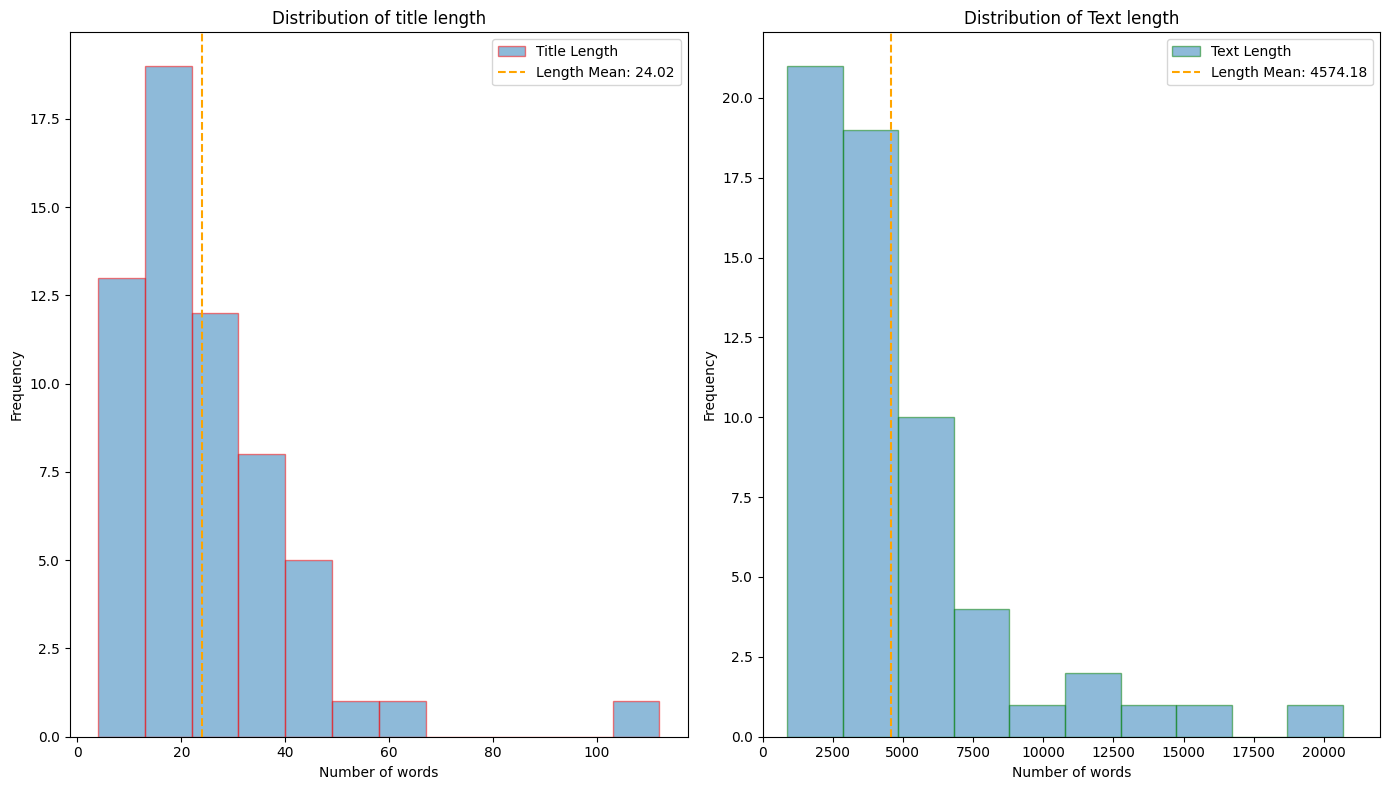


FILTERED DATASET


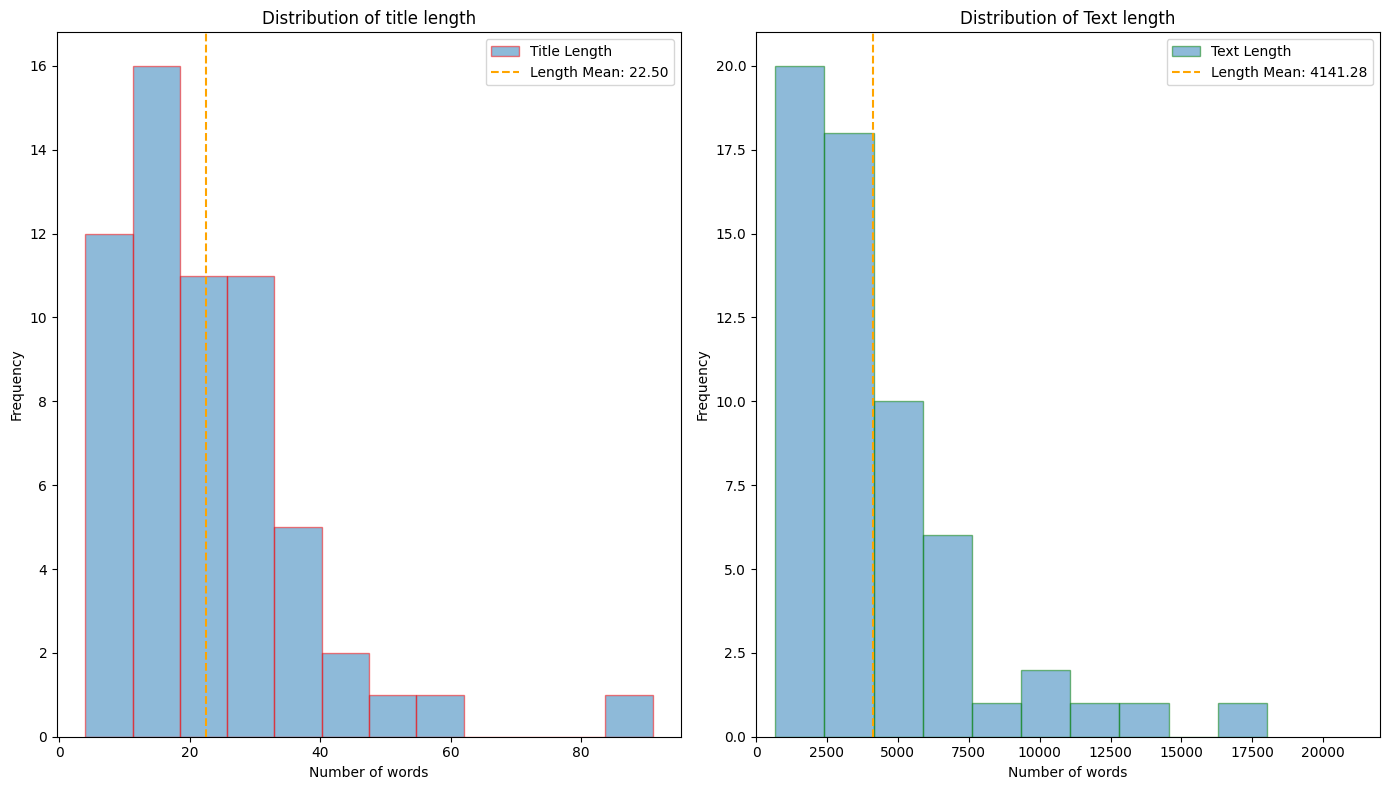

In [ ]:
def freedman_diaconis_bins(data):
    '''Calculate the number of bins using the Freedman-Diaconis rule.'''
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    n = len(data)
    bin_width = 2 * iqr / np.power(n, 1/3)
    num_bins = int(np.ceil((np.max(data) - np.min(data)) / bin_width))
    return num_bins

def text_length_analysis(dataset):
    # Text length analysis
    dataset['text_length'] = dataset['text'].apply(len)
    dataset['title_length']   = dataset['title'].apply(len)

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))

    text_mean = np.mean(dataset['text_length'])
    title_mean   = np.mean(dataset['title_length'])

    ax1.hist(dataset['title_length'], label='Title Length', alpha=0.5, bins=freedman_diaconis_bins(dataset['title_length']), edgecolor='red')
    ax1.axvline(title_mean, color='orange', linestyle='--', label=f"Length Mean: {title_mean:.2f}")
    ax1.set_xlabel('Number of words')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of title length')
    ax1.legend()

    ax2.hist(dataset['text_length'], label='Text Length', alpha=0.5, bins=freedman_diaconis_bins(dataset['text_length']), edgecolor='green')
    ax2.axvline(text_mean, color='orange', linestyle='--', label=f"Length Mean: {text_mean:.2f}")
    ax2.set_xlabel('Number of words')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Text length')
    ax2.set_xlim([0,22000])
    ax2.legend()

    plt.tight_layout()
    plt.xlim([0, 22000])
    plt.show()

print("RAW DATASET")
text_length_analysis(raw_dataset)

print("\nFILTERED DATASET")
text_length_analysis(dataset)

# Neural network

## Define model

In [ ]:
class RougeScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, tokenizer, max_sequence_len, test_texts, num_words_to_generate=10):
        self.model = model
        self.tokenizer = tokenizer
        self.max_sequence_len = max_sequence_len
        self.test_texts = test_texts
        self.num_words_to_generate = num_words_to_generate
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.aggregator = scoring.BootstrapAggregator()

    def on_epoch_end(self, epoch, logs=None):
        generated_texts = [self.generate_text(text) for text in self.test_texts]
        for ref, gen in zip(self.test_texts, generated_texts):
            scores = self.scorer.score(ref, gen)
            self.aggregator.add_scores(scores)
        result = self.aggregator.aggregate()
        print(f"Epoch {epoch+1}: ROUGE-1: {result['rouge1'].mid}, ROUGE-2: {result['rouge2'].mid}, ROUGE-L: {result['rougeL'].mid}")

    def generate_text(self, seed_text):
        for _ in range(self.num_words_to_generate):
            token_list = self.tokenizer.texts_to_sequences([seed_text])[0]
            token_list = pad_sequences([token_list], maxlen=self.max_sequence_len-1, padding='pre')
            predicted = self.model.predict(token_list, verbose=0)
            predicted_word_index = np.argmax(predicted, axis=1)
            predicted_word = self.tokenizer.index_word.get(predicted_word_index[0], '')
            seed_text += " " + predicted_word
        return seed_text

In [ ]:
texts = dataset['text'].tolist()

# Divide in train and test
train_texts, test_texts = train_test_split(texts, test_size=0.2, random_state=42)

In [ ]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
total_words = len(tokenizer.word_index) + 1

# Generate input sequences (3-grams)
input_sequences = []
for line in train_texts:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(3, len(token_list)):
        n_gram_sequence = token_list[i-5:i]
        input_sequences.append(n_gram_sequence)

# Sequence padding
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Create X (input sequences) and y (target words)
input_sequences = np.array(input_sequences)
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = to_categorical(y, num_classes=total_words)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 200, input_length=max_sequence_len-1))
model.add(LSTM(150))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-6))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 200)            1977600   
                                                                 
 lstm (LSTM)                 (None, 150)               210600    
                                                                 
 dense (Dense)               (None, 9888)              1493088   
                                                                 
Total params: 3681288 (14.04 MB)
Trainable params: 3681288 (14.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Fit model

In [ ]:
checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
rouge_callback = RougeScoreCallback(model, tokenizer, max_sequence_len, test_texts, num_words_to_generate=50)

num_epochs = 50
batch_size = 8

train_sh = model.fit(
    X, y,
    validation_split=0.05,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[checkpoint, earlystopping, rouge_callback],
    verbose=1
)

Epoch 1/50
2467/2468 [============================>.] - ETA: 0s - loss: 9.1989
Epoch 1: val_loss improved from inf to 9.19910, saving model to model.keras
Epoch 1: ROUGE-1: Score(precision=0.8607145781479009, recall=1.0, fmeasure=0.9238324773359968), ROUGE-2: Score(precision=0.860619414119361, recall=1.0, fmeasure=0.9235940500042674), ROUGE-L: Score(precision=0.861088499773095, recall=1.0, fmeasure=0.9240101599050752)
2468/2468 [==============================] - 233s 93ms/step - loss: 9.1989 - val_loss: 9.1991
Epoch 2/50
2467/2468 [============================>.] - ETA: 0s - loss: 9.1982
Epoch 2: val_loss did not improve from 9.19910
Epoch 2: ROUGE-1: Score(precision=0.8658368685320563, recall=1.0, fmeasure=0.926652739378492), ROUGE-2: Score(precision=0.865044423976322, recall=1.0, fmeasure=0.9261452298523658), ROUGE-L: Score(precision=0.8664265418662567, recall=1.0, fmeasure=0.9270715231671433)
2468/2468 [==============================] - 221s 90ms/step - loss: 9.1982 - val_loss: 9.19

## Evaluation of the model

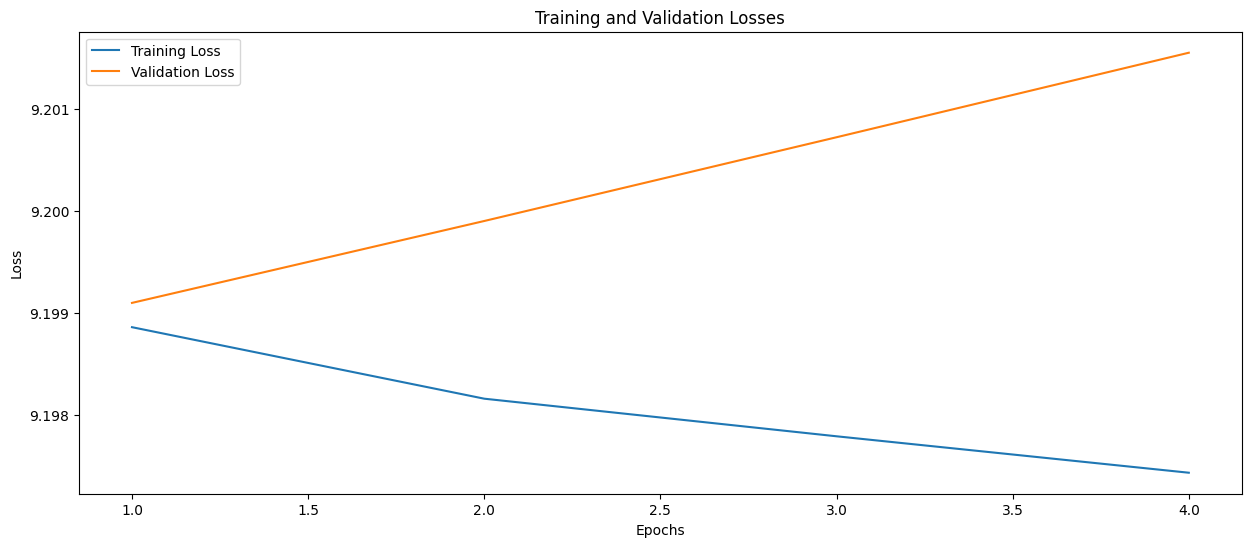

In [ ]:
epochs = np.arange(1, len(train_sh.history['loss']) + 1)

fig, ax2 = plt.subplots(figsize=(15,6))

# Plot the training and validation losses
ax2.plot(epochs, train_sh.history['loss'], label='Training Loss')
ax2.plot(epochs, train_sh.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Losses')

# Show the legend
plt.legend()
plt.show()

## Model testing

In [ ]:
# Load best saved model
model = load_model('model.keras')

In [ ]:
def generate_text(seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]  # Convert seed_text to token sequence
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')  # Pad sequence
        predicted = model.predict(token_list, verbose=0)  # Predict next word probabilities
        predicted_word_index = np.argmax(predicted, axis=1)[0]  # Get index of predicted word
        output_word = tokenizer.index_word.get(predicted_word_index, "")  # Convert index to word
        seed_text += " " + output_word  # Append predicted word to seed_text
    return seed_text

seed_text = "unayshi kay"
next_words = 30
print(generate_text(seed_text, next_words, max_sequence_len))

unayshi kay kayllapa yantatsun yantatsun chakrata parr harkay runaqa paykunashi kuchunmanna llamipakuqtsu puka qala parr hirishpa imatapsi willapa niykurshi ishkankuna kutikayaamurquu hanchashqa ishkankuna kaytami kaytami sachachaw chillapyaqninshi piraq wasinpa wasinpa churayashqa churayashqa


# N-grams model

In [ ]:
grams = 3

def filter_rare_words(texts, threshold=1):
    word_counter = Counter()
    for text in texts:
        word_counter.update(text.split())
    common_words = [word for word, count in word_counter.items() if count >= threshold]
    filtered_texts = [' '.join([word for word in text.split() if word in common_words]) for text in texts]
    return filtered_texts

texts = dataset['text'].tolist()
texts = filter_rare_words(texts)

# Create a model based on n-grams
def build_ngram_model(texts, n=grams):
    ngram_model = defaultdict(Counter)
    for text in texts:
        tokens = text.split()
        for i in range(len(tokens) - n):
            ngram = tuple(tokens[i:i+n-1])
            next_word = tokens[i+n-1]
            ngram_model[ngram][next_word] += 1
    return ngram_model

ngram_model = build_ngram_model(texts, n=grams)

# Generate text using ngram_model
def generate_text(ngram_model, seed_text, next_words, n):
    seed_tokens = seed_text.split()
    output = seed_tokens[:]
    for _ in range(next_words):
        ngram = tuple(output[-(n-1):])
        next_word_candidates = ngram_model.get(ngram, None)
        if not next_word_candidates:
            break
        next_word = random.choices(list(next_word_candidates.keys()), weights=list(next_word_candidates.values()))[0]
        output.append(next_word)
    return ' '.join(output)

seed_text = "unayshi kay"
next_words = 30
print(generate_text(ngram_model, seed_text, next_words, n=grams))

unayshi kay shumaq chakrata rachirimushun tayta illapa mikachinapaq chayshi hatunkaray illapa chillapyaqkuna nishqan mayakunaq chayshi rachiy ushapakunaq yuraq sarata mallaqarqa chay sarakunallata mikunki ninaq wasinchawqa taytankuna kushishqa chaskiyaanaq wamraqa qallwashwan yuraq saran


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=ac7154529d0130f98a206843236ea3c00e7518a2e5cf4161cf681d6c63af9656
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
ERROR: Cannot uninstall 'blinker'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
Tensorflow version 2.15.0
Alphabet length: 24
Regex: ^(?:a|i|u|aa|ii|uu|ch|h|k|l|ll|m|n|ñ|p|q|r|s|sh|t|ts|tr|w|y|\.|,|!|\?|:|;|\-|\(|\)|\[|\]|\{|\}|"|'|\.\.\.|–|—|“|”|‘|’|¡|¿|…|«|»|_|/|\*)+$
RAW DATASET


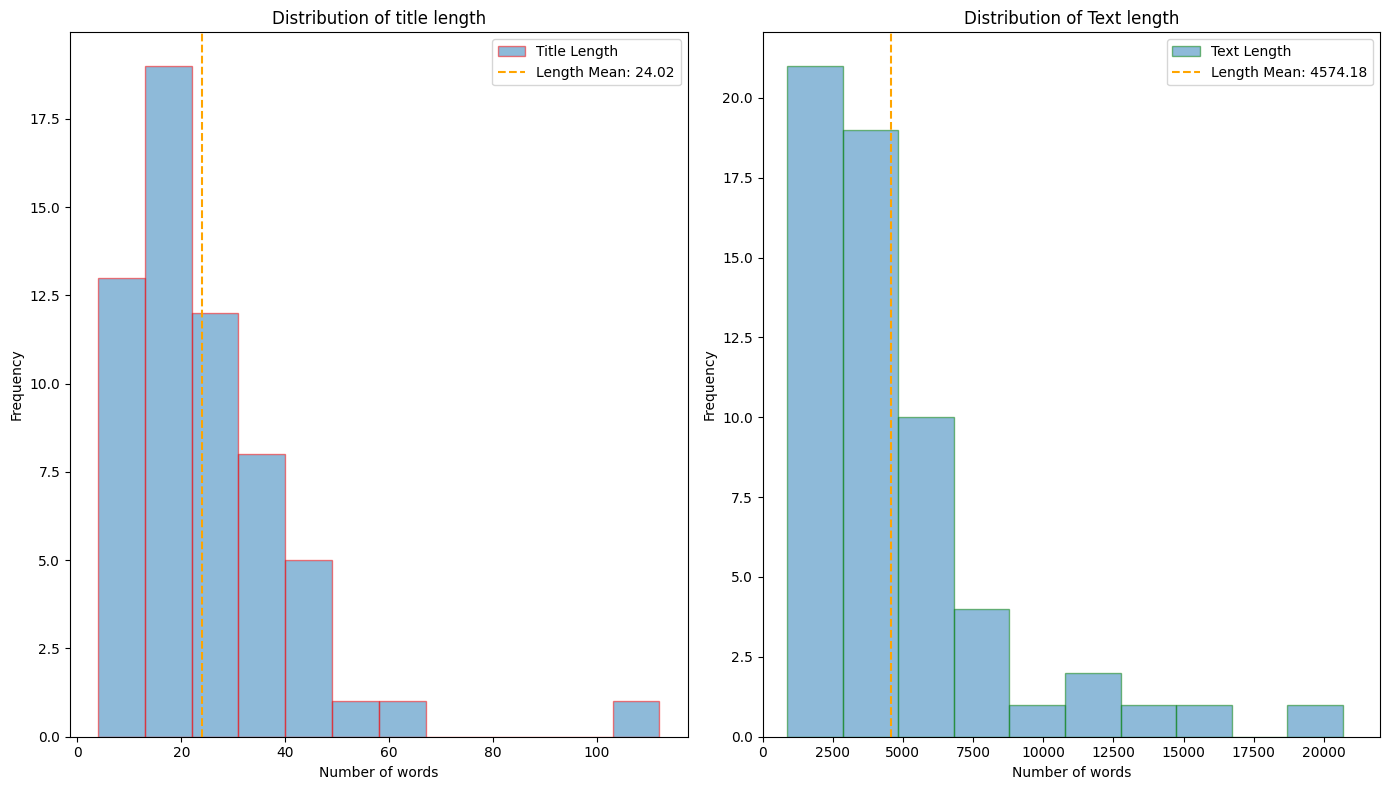


FILTERED DATASET


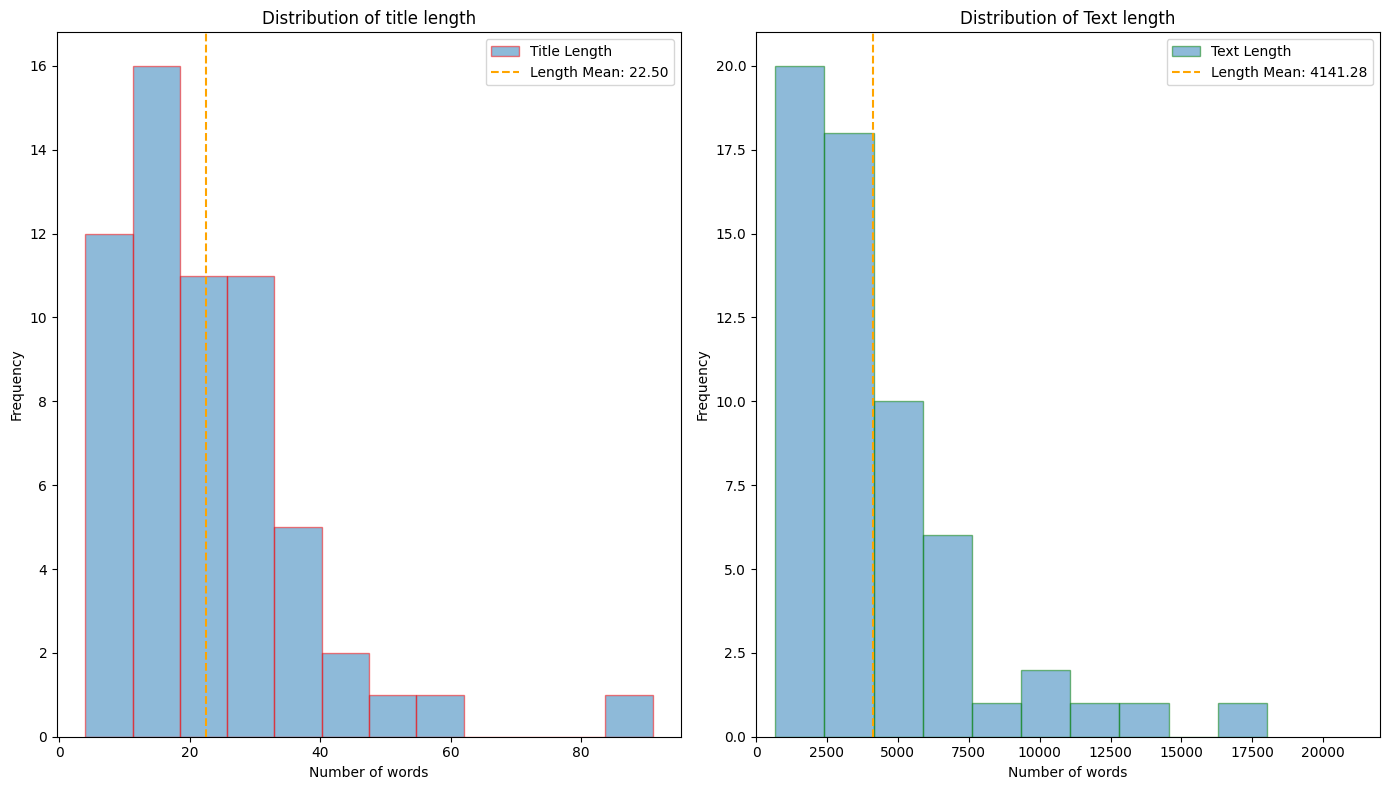

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 200)            1977600   
                                                                 
 lstm (LSTM)                 (None, 150)               210600    
                                                                 
 dense (Dense)               (None, 9888)              1493088   
                                                                 
Total params: 3681288 (14.04 MB)
Trainable params: 3681288 (14.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


NameError: name 'rouge_scorer' is not defined

In [ ]:
# Importar bibliotecas y configuración del entorno EJECUTAR ESTO Y DEJARLO PRENDIDO PARA EL BACK
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from collections import defaultdict, Counter
import random
import pickle

import tensorflow as tf

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

!pip install rouge-score pyngrok
!pip install pyngrok rouge-score
!pip install flask-cors

from pyngrok import ngrok

# Configura tu authtoken aquí
ngrok.set_auth_token("2ihbV7UKHQhDnCtj51aiaHZ6kwn_5LkccgAS2QVMm4Df7bUcM")

# Usar TPU
print("Tensorflow version " + tf.__version__)


# Preprocesamiento y análisis
fileroute = 'https://github.com/U20212419/TA_TACC/blob/main/corpus.csv?raw=true'
raw_dataset = pd.read_csv(fileroute, delimiter=',', encoding='latin-1')
raw_dataset.head()

alphabet = ['a', 'i', 'u', 'aa', 'ii', 'uu', 'ch', 'h', 'k', 'l', 'll', 'm', 'n', 'ñ', 'p', 'q', 'r', 's', 'sh', 't', 'ts', 'tr', 'w', 'y']
punctuation = ['.', ',', '!', '?', ':', ';', '-', '(', ')', '[', ']', '{', '}', '"', "'", '...', '–', '—', '“', '”', '‘', '’', '¡', '¿', '…', '«', '»', '_', '/', '*']
print("Alphabet length: {}".format(len(alphabet)))

alphabet_pattern = '|'.join(re.escape(char) for char in alphabet + punctuation)
pattern = f'^(?:{alphabet_pattern})+$'
print("Regex: {}".format(pattern))

def is_valid_word(word):
    return bool(re.match(pattern, word, re.IGNORECASE))

def filter_text(text):
    words = text.split()
    valid_words = filter(is_valid_word, words)
    return ' '.join(valid_words)

def remove_punctuation(text):
    text = re.sub(f"[{re.escape(''.join(punctuation))}]", "", text)
    return text

def preprocessing(dataset):
    dataset['text'] = dataset['text'].apply(remove_punctuation)
    dataset['title'] = dataset['title'].apply(remove_punctuation)
    dataset['text'] = dataset['text'].apply(filter_text)
    dataset['title'] = dataset['title'].apply(filter_text)
    dataset['text'] = dataset['text'].str.lower()
    dataset['title'] = dataset['title'].str.lower()
    dataset['text'] = dataset['text'].apply(lambda x: ' '.join(x.split()))
    dataset['title'] = dataset['title'].apply(lambda x: ' '.join(x.split()))
    dataset = dataset[dataset['text'].str.strip().astype(bool)]
    dataset = dataset[dataset['title'].str.strip().astype(bool)]
    return dataset

dataset = raw_dataset.copy()
dataset = preprocessing(dataset)
dataset.head()

def freedman_diaconis_bins(data):
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    n = len(data)
    bin_width = 2 * iqr / np.power(n, 1/3)
    num_bins = int(np.ceil((np.max(data) - np.min(data)) / bin_width))
    return num_bins

def text_length_analysis(dataset):
    dataset['text_length'] = dataset['text'].apply(len)
    dataset['title_length'] = dataset['title'].apply(len)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

    text_mean = np.mean(dataset['text_length'])
    title_mean = np.mean(dataset['title_length'])

    ax1.hist(dataset['title_length'], label='Title Length', alpha=0.5, bins=freedman_diaconis_bins(dataset['title_length']), edgecolor='red')
    ax1.axvline(title_mean, color='orange', linestyle='--', label=f"Length Mean: {title_mean:.2f}")
    ax1.set_xlabel('Number of words')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of title length')
    ax1.legend()

    ax2.hist(dataset['text_length'], label='Text Length', alpha=0.5, bins=freedman_diaconis_bins(dataset['text_length']), edgecolor='green')
    ax2.axvline(text_mean, color='orange', linestyle='--', label=f"Length Mean: {text_mean:.2f}")
    ax2.set_xlabel('Number of words')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Text length')
    ax2.set_xlim([0, 22000])
    ax2.legend()

    plt.tight_layout()
    plt.xlim([0, 22000])
    plt.show()

print("RAW DATASET")
text_length_analysis(raw_dataset)

print("\nFILTERED DATASET")
text_length_analysis(dataset)

# Red neuronal
class RougeScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, tokenizer, max_sequence_len, test_texts, num_words_to_generate=10):
        self.model = model
        self.tokenizer = tokenizer
        self.max_sequence_len = max_sequence_len
        self.test_texts = test_texts
        self.num_words_to_generate = num_words_to_generate
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.aggregator = scoring.BootstrapAggregator()

    def on_epoch_end(self, epoch, logs=None):
        generated_texts = [self.generate_text(text) for text in self.test_texts]
        for ref, gen in zip(self.test_texts, generated_texts):
            scores = self.scorer.score(ref, gen)
            self.aggregator.add_scores(scores)
        result = self.aggregator.aggregate()
        print(f"Epoch {epoch+1}: ROUGE-1: {result['rouge1'].mid}, ROUGE-2: {result['rouge2'].mid}, ROUGE-L: {result['rougeL'].mid}")

    def generate_text(self, seed_text):
        for _ in range(self.num_words_to_generate):
            token_list = self.tokenizer.texts_to_sequences([seed_text])[0]
            token_list = pad_sequences([token_list], maxlen=self.max_sequence_len-1, padding='pre')
            predicted = self.model.predict(token_list, verbose=0)
            predicted_word_index = np.argmax(predicted, axis=1)
            predicted_word = self.tokenizer.index_word.get(predicted_word_index[0], '')
            seed_text += " " + predicted_word
        return seed_text

texts = dataset['text'].tolist()
train_texts, test_texts = train_test_split(texts, test_size=0.2, random_state=42)

# Tokenización
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
total_words = len(tokenizer.word_index) + 1

# Generar secuencias de entrada (3-grams)
input_sequences = []
for line in train_texts:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(3, len(token_list)):
        n_gram_sequence = token_list[i-5:i]
        input_sequences.append(n_gram_sequence)

# Rellenar secuencias
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Crear X (secuencias de entrada) y y (palabras objetivo)
input_sequences = np.array(input_sequences)
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = to_categorical(y, num_classes=total_words)

# Definir modelo
model = Sequential()
model.add(Embedding(total_words, 200, input_length=max_sequence_len-1))
model.add(LSTM(150))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-6))
model.summary()

# Ajustar modelo
checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
rouge_callback = RougeScoreCallback(model, tokenizer, max_sequence_len, test_texts, num_words_to_generate=50)

num_epochs = 50
batch_size = 8

train_sh = model.fit(
    X, y,
    validation_split=0.05,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[checkpoint, earlystopping, rouge_callback],
    verbose=1
)

# Evaluación del modelo
epochs = np.arange(1, len(train_sh.history['loss']) + 1)
fig, ax2 = plt.subplots(figsize=(15, 6))
ax2.plot(epochs, train_sh.history['loss'], label='Training Loss')
ax2.plot(epochs, train_sh.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Losses')
plt.legend()
plt.show()

# Probar el modelo
model = load_model('model.keras')

def generate_text(seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted, axis=1)[0]
        output_word = tokenizer.index_word.get(predicted_word_index, "")
        seed_text += " " + output_word
    return seed_text

seed_text = "unayshi kay"
next_words = 30
print(generate_text(seed_text, next_words, max_sequence_len))

# Guardar el tokenizador
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Implementación del servicio API con Flask y pyngrok

from flask import Flask, request, jsonify
from flask_cors import CORS

app = Flask(__name__)
CORS(app)  # Habilitar CORS

# Cargar el modelo y el tokenizador
model = load_model('model.keras')
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

@app.route('/generate_text', methods=['POST'])
def generate_text_api():
    data = request.get_json()
    seed_text = data['seed_text']
    next_words = data['next_words']

    generated_text = generate_text(seed_text, next_words, max_sequence_len)
    return jsonify({"generated_text": generated_text})

def generate_text(seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted, axis=1)[0]
        output_word = tokenizer.index_word.get(predicted_word_index, "")
        seed_text += " " + output_word
    return seed_text

# Abre un túnel ngrok para que el servidor Flask sea accesible públicamente
public_url = ngrok.connect(5000)
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:5000\"".format(public_url))

if __name__ == '__main__':
    app.run()

